In [1]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 M

In [5]:
!pip install fsspec==2025.3.0

  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [6]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch

In [8]:

!pip install -q kaggle


In [9]:
# Upload your kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"haseebashraf25","key":"20b6df4f7182c70009076a65201f141f"}'}

In [10]:
# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
# Download the dataset
!kaggle datasets download -d adityajn105/flickr8k

# Unzip it
!unzip -q flickr8k.zip -d flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0


In [31]:
DATASET_PATH = '/content/flickr8k'
CAPTIONS_FILE = os.path.join(DATASET_PATH, 'captions.txt')
IMAGES_PATH = os.path.join(DATASET_PATH, 'Images/')


In [79]:
# Load and process captions
df = pd.read_csv(CAPTIONS_FILE, sep=',', names=["image", "caption"])


In [62]:
df["caption"] = df["caption"][1:]

In [63]:
df["caption"]

,caption
0,NaN
1,A child in a pink dress is climbing up a set o...
2,A girl going into a wooden building .
3,A little girl climbing into a wooden playhouse .
4,A little girl climbing the stairs to her playh...
...,...
40451,A man in a pink shirt climbs a rock face
40452,A man is rock climbing high in the air .
40453,A person in a red shirt climbing up a rock fac...
40454,A rock climber in a red shirt .


In [64]:
df = df.dropna().reset_index(drop=True)

In [65]:
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [66]:
df = df[:8000]

In [67]:
from transformers import AutoProcessor
from PIL import Image

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

class Flickr8kDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_dir, row["image"])
        caption = row["caption"]

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Process image
        encoding = self.processor(images=image, return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = caption

        return encoding

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


In [68]:
from transformers import Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model

model = Blip2ForConditionalGeneration.from_pretrained(
    "ybelkada/blip2-opt-2.7b-fp16-sharded",
    device_map="auto",
    load_in_8bit=True
)

# Apply LoRA
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)
model = get_peft_model(model, config)
model.print_trainable_parameters()


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [69]:
# Load dataset
train_dataset = Flickr8kDataset(df, IMAGES_PATH, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

# Set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.train()

# Training loop
for epoch in range(2):  # Use small epochs for testing, increase later
    print(f"Epoch: {epoch}")
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.float16)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss

        print(f"Batch {idx} Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


Streaming output truncated to the last 5000 lines.
Batch 335 Loss: 1.4795
Batch 336 Loss: 1.5576
Batch 337 Loss: 1.4199
Batch 338 Loss: 1.5615
Batch 339 Loss: 1.7939
Batch 340 Loss: 1.9326
Batch 341 Loss: 1.4307
Batch 342 Loss: 1.7461
Batch 343 Loss: 1.8320
Batch 344 Loss: 1.4062
Batch 345 Loss: 2.1562
Batch 346 Loss: 1.6670
Batch 347 Loss: 1.7100
Batch 348 Loss: 3.1895
Batch 349 Loss: 2.3809
Batch 350 Loss: 2.2988
Batch 351 Loss: 1.7236
Batch 352 Loss: 1.4141
Batch 353 Loss: 1.6465
Batch 354 Loss: 1.6191
Batch 355 Loss: 1.6094
Batch 356 Loss: 2.3398
Batch 357 Loss: 1.5752
Batch 358 Loss: 1.7100
Batch 359 Loss: 1.7656
Batch 360 Loss: 1.6787
Batch 361 Loss: 1.6562
Batch 362 Loss: 1.2441
Batch 363 Loss: 2.2891
Batch 364 Loss: 1.8135
Batch 365 Loss: 1.1621
Batch 366 Loss: 1.7168
Batch 367 Loss: 1.9971
Batch 368 Loss: 1.5889
Batch 369 Loss: 1.3232
Batch 370 Loss: 1.5977
Batch 371 Loss: 2.0684
Batch 372 Loss: 1.1348
Batch 373 Loss: 1.3867
Batch 374 Loss: 1.5586
Batch 375 Loss: 1.8691
Batch 

In [70]:
# Example prediction
sample_image = Image.open(os.path.join(IMAGES_PATH, df.iloc[0]["image"])).convert('RGB')
inputs = processor(images=sample_image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=25)
caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Generated caption:", caption)


Generated caption: A little girl in a pink dress dress is climbing up to the stepss to a wooden .


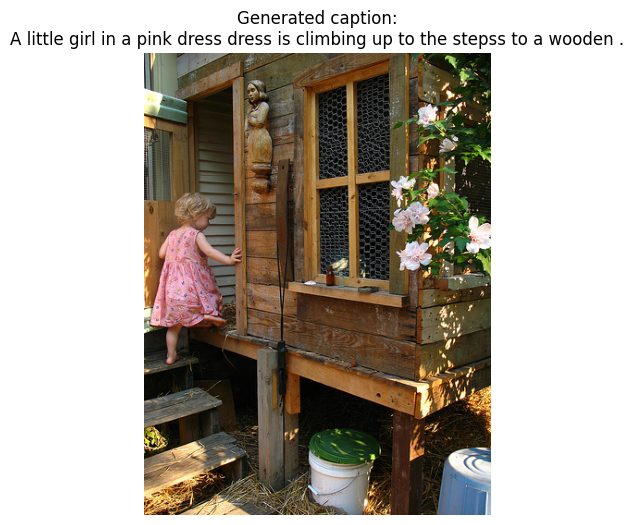

In [71]:
import matplotlib.pyplot as plt

# Show the sample image with the generated caption
plt.figure(figsize=(6,6))
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Generated caption:\n{caption}", fontsize=12)
plt.show()


Generated caption: Two white dog and black dog play on a road .


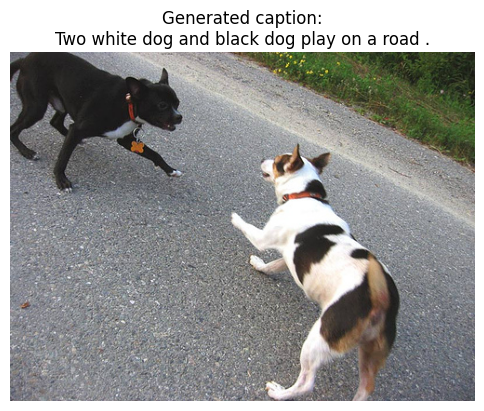

In [72]:
# Load a sample image
sample_image = Image.open(os.path.join(IMAGES_PATH, df.iloc[5]["image"])).convert('RGB')

# Prepare inputs
inputs = processor(images=sample_image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=25)

# Decode caption
caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Generated caption:", caption)

# Show image with caption
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Generated caption:\n{caption}", fontsize=12)
plt.show()


Generated caption: A little girl in a pink dress dress is climbing up a wooden .


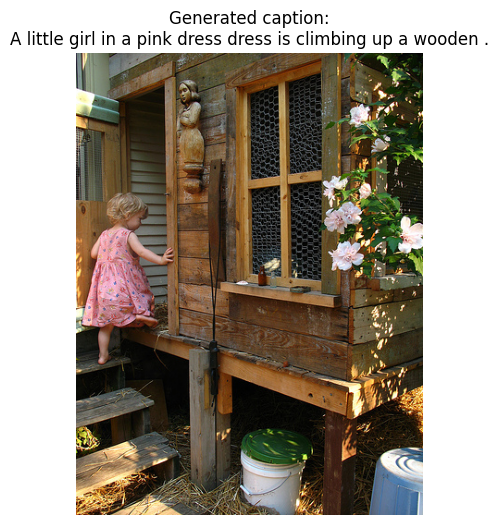

In [73]:
# Load a sample image
sample_image = Image.open(os.path.join(IMAGES_PATH, df.iloc[0]["image"])).convert('RGB')

# Prepare inputs
inputs = processor(images=sample_image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=25)

# Decode caption
caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Generated caption:", caption)

# Show image with caption
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Generated caption:\n{caption}", fontsize=12)
plt.show()


Generated caption: A man is sitting on a bench with a dog dog on a bench .


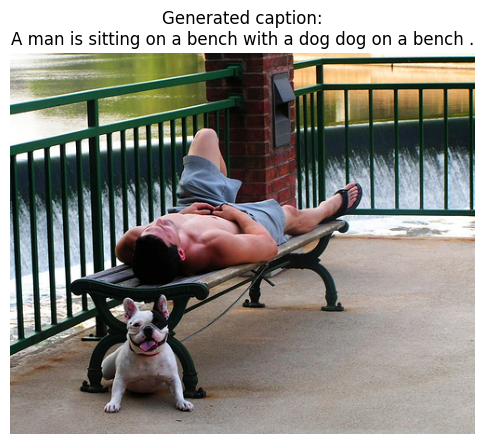

In [74]:
# Load a sample image
sample_image = Image.open(os.path.join(IMAGES_PATH, df.iloc[15]["image"])).convert('RGB')

# Prepare inputs
inputs = processor(images=sample_image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=25)

# Decode caption
caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Generated caption:", caption)

# Show image with caption
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Generated caption:\n{caption}", fontsize=12)
plt.show()


Generated caption: A man wearing a hat with a beer label .


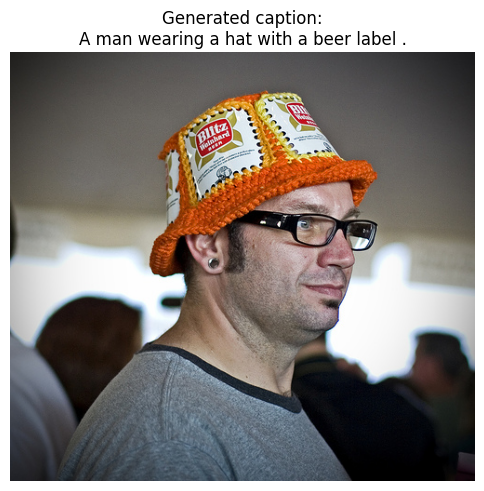

In [75]:
# Load a sample image
sample_image = Image.open(os.path.join(IMAGES_PATH, df.iloc[20]["image"])).convert('RGB')

# Prepare inputs
inputs = processor(images=sample_image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=25)

# Decode caption
caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Generated caption:", caption)

# Show image with caption
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Generated caption:\n{caption}", fontsize=12)
plt.show()


Generated caption: A black dog jumps on a tree branch .


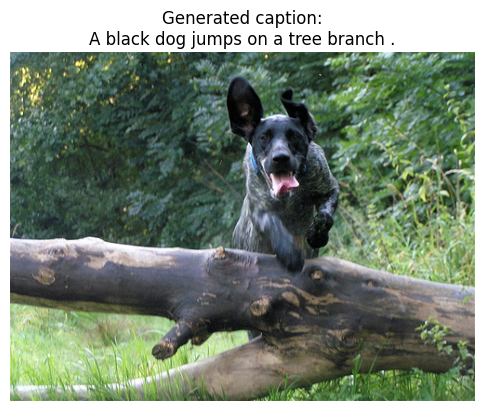

In [76]:
# Load a sample image
sample_image = Image.open(os.path.join(IMAGES_PATH, df.iloc[49]["image"])).convert('RGB')

# Prepare inputs
inputs = processor(images=sample_image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=25)

# Decode caption
caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Generated caption:", caption)

# Show image with caption
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Generated caption:\n{caption}", fontsize=12)
plt.show()


In [77]:
!pip install evaluate pycocoevalcap --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.5 MB/s eta 0:00:00


In [78]:
import evaluate
from tqdm import tqdm
from PIL import Image
import torch
import os

# Load metrics
bleu = evaluate.load("bleu")
cider = evaluate.load("cider")
df = pd.read_csv(CAPTIONS_FILE, sep=',', names=["image", "caption"])

# Subset of data
subset_df = df[8001:8092].reset_index(drop=True)

# Prepare references and predictions
references = {}
predictions = []

for idx in tqdm(range(len(subset_df))):
    image_name = subset_df.iloc[idx]['image']

    # Load image
    image_path = os.path.join(IMAGES_PATH, image_name)
    image = Image.open(image_path).convert('RGB')

    # Generate caption
    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=25)
    predicted_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Save prediction
    predictions.append(predicted_caption)

    # Prepare ground-truth references
    if image_name not in references:
        gt = df[df['image'] == image_name]['caption'].tolist()
        references[image_name] = gt

# Build reference and prediction lists for scoring
gt_list = [references[name] for name in subset_df['image']]
pred_list = predictions


FileNotFoundError: Couldn't find a module script at /content/cider/cider.py. Module 'cider' doesn't exist on the Hugging Face Hub either.

In [80]:
import evaluate
from tqdm import tqdm
from PIL import Image
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

bleu = evaluate.load("bleu")
df = pd.read_csv(CAPTIONS_FILE, sep=',', names=["image", "caption"])

# Get subset
subset_df = df[8001:8092].reset_index(drop=True)

# Collect predictions and references
predictions = []
references = {}

for idx in tqdm(range(len(subset_df))):
    row = subset_df.iloc[idx]
    image_name = row['image']

    image_path = os.path.join(IMAGES_PATH, image_name)
    image = Image.open(image_path).convert('RGB')

    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=25)
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    predictions.append(caption)

    if image_name not in references:
        refs = df[df['image'] == image_name]['caption'].tolist()
        references[image_name] = refs

# Prepare for BLEU
gt_list = [references[name] for name in subset_df["image"]]
pred_list = predictions

bleu_score = bleu.compute(predictions=pred_list, references=gt_list)
print("BLEU:", bleu_score)


100%|██████████| 91/91 [04:45<00:00,  3.14s/it]

BLEU: {'bleu': 0.3372973481155598, 'precisions': [0.8022426095820592, 0.4764044943820225, 0.25782227784730916, 0.13135593220338984], 'brevity_penalty': 1.0, 'length_ratio': 1.2976190476190477, 'translation_length': 981, 'reference_length': 756}


In [81]:
# Prepare COCO-style input
gts = {}
res = {}

for i, img in enumerate(subset_df["image"]):
    gts[str(i)] = [{"caption": cap} for cap in references[img]]
    res[str(i)] = [{"caption": predictions[i]}]

# Tokenize
tokenizer = PTBTokenizer()
gts_tokenized = tokenizer.tokenize(gts)
res_tokenized = tokenizer.tokenize(res)

# Compute CIDEr
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(gts_tokenized, res_tokenized)
print("CIDEr:", cider_score)


CIDEr: 0.9293435340659406
